<a href="https://colab.research.google.com/github/kushptl1/Insider_threat_analysis/blob/main/Insider_threat_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2531003 entries, 0 to 2531002
Data columns (total 11 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           object        
 1   date         datetime64[ns]
 2   user         object        
 3   pc           object        
 4   to           object        
 5   cc           object        
 6   bcc          object        
 7   from         object        
 8   size         float64       
 9   attachments  float64       
 10  content      object        
dtypes: datetime64[ns](1), float64(2), object(8)
memory usage: 212.4+ MB
None
                                date          size   attachments
count                        2531003  2.531002e+06  2.531002e+06
mean   2010-08-22 05:32:56.607964416  2.999145e+04  4.033659e-01
min              2010-01-02 07:11:45  6.182000e+03  0.000000e+00
25%       2010-04-23 14:00:38.500000  2.285700e+04  0.000000e+00
50%              2010-08-17 18:09:29  2.845500e+04  0.0

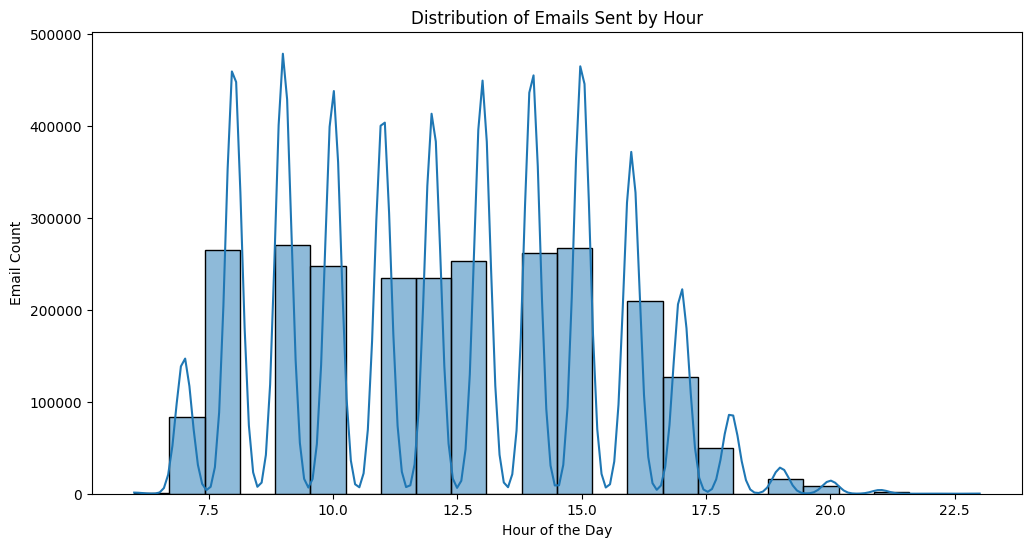

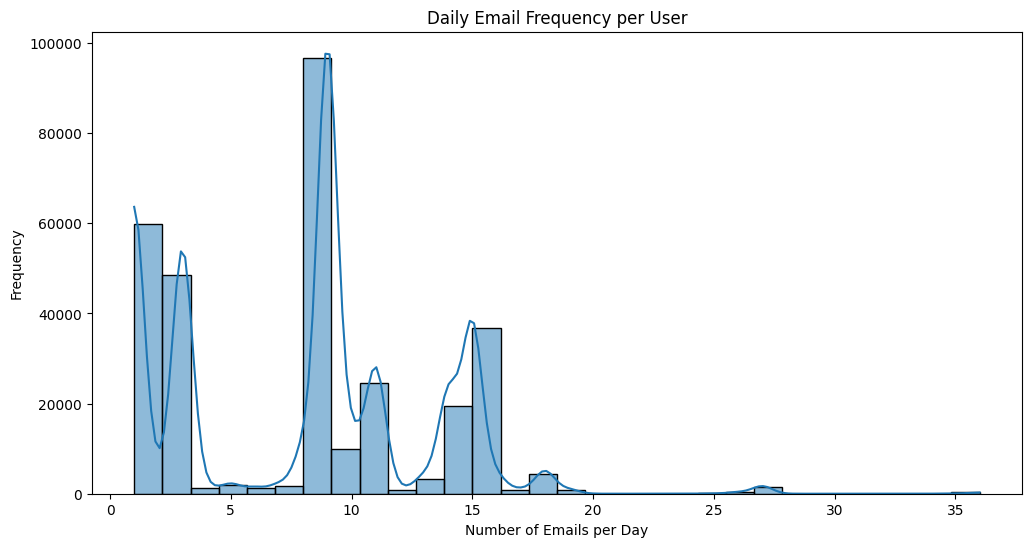

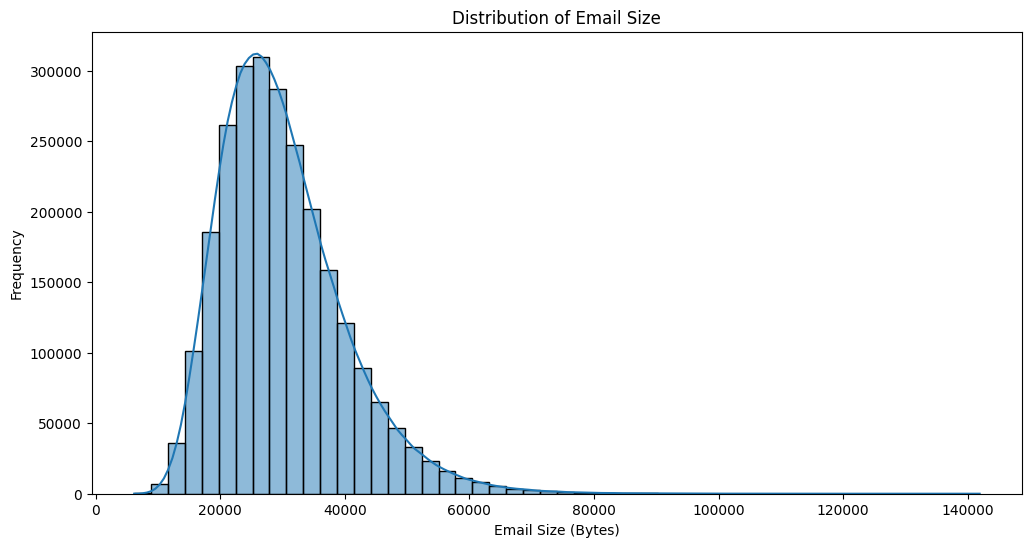

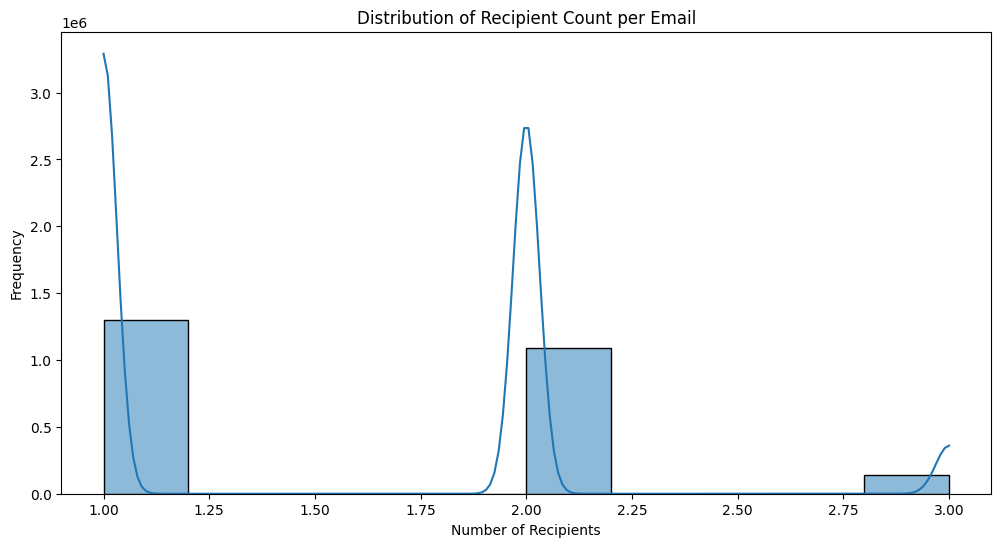

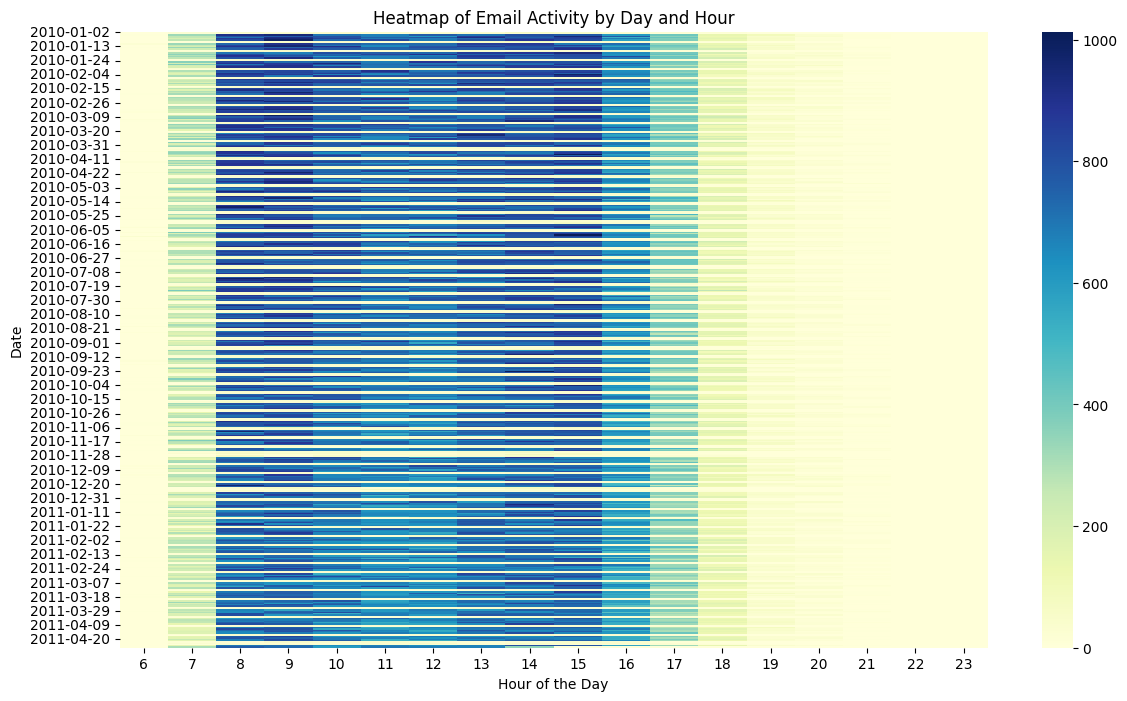

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2531003 entries, 0 to 2531002
Data columns (total 13 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               object        
 1   date             datetime64[ns]
 2   user             object        
 3   pc               object        
 4   to               object        
 5   cc               object        
 6   bcc              object        
 7   from             object        
 8   size             float64       
 9   attachments      float64       
 10  content          object        
 11  hour             int32         
 12  recipient_count  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(8)
memory usage: 241.4+ MB
Missing Values:
 id                       0
date                     0
user                     0
pc                       0
to                       0
cc                 1556479
bcc                2129855
from                     1
size  

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Importing Dataset and doing the Exploratory Data Analysis.

# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import Dense, GRU
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from scipy.stats import zscore # Import the zscore function from scipy.stats

# ... other imports ...
from sklearn.model_selection import train_test_split, KFold  # Import KFold
from sklearn.model_selection import cross_val_predict, cross_val_score # Import cross_val_predict, cross_val_score



# Load the dataset
df = pd.read_csv("/content/email.csv")

# Convert date field to datetime, if not already done
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Basic dataset overview
print(df.info())
print(df.describe())
print(df.head())

# 1. Distribution of Emails Sent by Hour
df['hour'] = df['date'].dt.hour
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='hour', bins=24, kde=True)
plt.title('Distribution of Emails Sent by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Email Count')
plt.show()

# 2. Daily Email Frequency per User
daily_emails = df.groupby([df['date'].dt.date, 'user']).size().reset_index(name='email_count')
plt.figure(figsize=(12, 6))
sns.histplot(data=daily_emails, x='email_count', bins=30, kde=True)
plt.title('Daily Email Frequency per User')
plt.xlabel('Number of Emails per Day')
plt.ylabel('Frequency')
plt.show()

# 3. Average Email Size Distribution (in Bytes)
plt.figure(figsize=(12, 6))
sns.histplot(df['size'].dropna(), bins=50, kde=True)
plt.title('Distribution of Email Size')
plt.xlabel('Email Size (Bytes)')
plt.ylabel('Frequency')
plt.show()

# 4. Count of Recipients per Email
df['recipient_count'] = df[['to', 'cc', 'bcc']].apply(lambda x: sum(pd.notnull(x)), axis=1)
plt.figure(figsize=(12, 6))
sns.histplot(df['recipient_count'], bins=10, kde=True)
plt.title('Distribution of Recipient Count per Email')
plt.xlabel('Number of Recipients')
plt.ylabel('Frequency')
plt.show()

# 5. Heatmap of Email Activity by Day and Hour
email_counts = df.groupby([df['date'].dt.date, df['date'].dt.hour]).size().unstack(fill_value=0)
plt.figure(figsize=(14, 8))
sns.heatmap(email_counts, cmap="YlGnBu", cbar=True)
plt.title('Heatmap of Email Activity by Day and Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Date')
plt.show()

# Data Cleaning and feature Engineering

missing_values = df.isnull().sum()

# Basic statistics and info
data_info = df.describe()
data_info = df.info()

# Exploratory Data Analysis
email_volume = df.groupby(df['date'].dt.date).size()

# Frequency of emails by user
user_frequency = df['user'].value_counts()

# Number of attachments analysis
attachment_analysis = df['attachments'].value_counts()

# Display results
print("Missing Values:\n", missing_values)

print("Data Info:\n", data_info)

print("Email Volume Over Time:\n", email_volume)

print("User Frequency:\n", user_frequency)

print("Attachment Analysis:\n", attachment_analysis)

# defining the new feature which would be the target feature - Anamoly

df['hour'] = pd.to_datetime(df['date']).dt.hour
df['recipient_count'] = df[['to', 'cc', 'bcc']].apply(lambda x: sum(pd.notnull(x)), axis=1)

size_threshold = df['size'].quantile(0.95)
recipient_threshold = df['recipient_count'].quantile(0.95)
night_hours = [0, 1, 2, 3, 4, 5, 22, 23]

df['size_zscore'] = zscore(df['size'])
df['recipient_count_zscore'] = zscore(df['recipient_count'])

df['anomaly'] = (
    (df['size'] > size_threshold) |
    (df['recipient_count'] > recipient_threshold) |
    (df['hour'].isin(night_hours)) |
    (df['size_zscore'] > 3) |  # Anomalous if size z-score is above 3
    (df['recipient_count_zscore'] > 3)  # Anomalous if recipient count z-score is above 3
).astype(int)

##############################################################################################


# Model #1: Logistic Regression:

X = df[['size', 'recipient_count', 'hour', 'attachments']]  # Use relevant features
y = df['anomaly']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False)
    plt.title('Confusion Matrix for Logistic Regression')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(cm)

##############################################################################################

# Model #2: Support-Vector Machine with Linear & RBF kernels

X = df[['size', 'recipient_count', 'hour', 'attachments']]  # Use relevant features
y = df['anomaly']  # Target variable: anomaly (1 for anomalous, 0 for normal)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to plot confusion matrix heatmap
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

kernels = ['linear', 'rbf']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for kernel in kernels:
    svm_model = SVC(kernel=kernel, C=1.0, gamma='scale')

    y_pred_train = cross_val_predict(svm_model, X_train_scaled, y_train, cv=kf)

    print(f"SVM with {kernel.capitalize()} Kernel (Train Set) - Classification Report:")
    print(classification_report(y_train, y_pred_train))

    plot_confusion_matrix(y_train, y_pred_train, f"SVM with {kernel.capitalize()} Kernel (Train Set)")

    svm_model.fit(X_train_scaled, y_train)
    y_pred_test = svm_model.predict(X_test_scaled)

    print(f"SVM with {kernel.capitalize()} Kernel (Test Set) - Classification Report:")
    print(classification_report(y_test, y_pred_test))

    plot_confusion_matrix(y_test, y_pred_test, f"SVM with {kernel.capitalize()} Kernel (Test Set)")

##############################################################################################

# Model #3: Ensemble Model: Bagging of KNN and Random forest

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_model = KNeighborsClassifier(n_neighbors=5)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Ensemble model using Voting Classifier (Bagging)
ensemble_model = VotingClassifier(estimators=[('knn', knn_model), ('rf', rf_model)], voting='hard')

ensemble_model.fit(X_train_scaled, y_train)

y_pred = ensemble_model.predict(X_test_scaled)

print("Ensemble Model (KNN + RF) - Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(y_test, y_pred, "Ensemble Model (KNN + RF)")

##############################################################################################

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('email.csv')

# Check for missing columns and derive them if possible
if 'to' in df.columns and 'cc' in df.columns and 'bcc' in df.columns:
    df['recipient_count'] = df[['to', 'cc', 'bcc']].apply(lambda row: sum([len(str(x).split(',')) for x in row if pd.notna(x)]), axis=1)
else:
    print("Columns required to compute recipient_count (to, cc, bcc) are missing.")

if 'date' in df.columns:
    df['hour'] = pd.to_datetime(df['date'], errors='coerce').dt.hour
else:
    print("Column 'date' required to compute 'hour' is missing.")

if 'anomaly' not in df.columns:
    print("Column 'anomaly' is missing. Creating a dummy column with default values (0 for normal).")
    df['anomaly'] = 0  # Replace with real anomaly labels or detection logic

# Verify required columns
required_columns = ['size', 'recipient_count', 'hour', 'attachments', 'anomaly']
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    raise KeyError(f"The following required columns are missing from the dataset: {missing_columns}")

# Data Preprocessing
df = df.dropna(subset=required_columns)  # Drop rows with missing values in required columns
print("Dataframe shape after preprocessing:", df.shape)

if len(df) == 0:
    raise ValueError("Dataset is empty after preprocessing. Please check data quality.")

# Features and target variable
X = df[['size', 'recipient_count', 'hour', 'attachments']]
y = df['anomaly']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

##############################################################################################
# Model #1: Logistic Regression
print("\n--- Logistic Regression ---")
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")

##############################################################################################
# Model #2: Support Vector Machine (SVM)
# print("\n--- Support Vector Machine (SVM) ---")
# kernels = ['linear', 'rbf']
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# for kernel in kernels:
#     svm_model = SVC(kernel=kernel, C=1.0, gamma='scale')

#     # Cross-validation on training set
#     y_pred_train = cross_val_predict(svm_model, X_train_scaled, y_train, cv=kf)

#     print(f"SVM with {kernel.capitalize()} Kernel (Train Set) - Classification Report:")
#     print(classification_report(y_train, y_pred_train))
#     plot_confusion_matrix(y_train, y_pred_train, f"SVM with {kernel.capitalize()} Kernel (Train Set)")

#     # Fit and evaluate on test set
#     svm_model.fit(X_train_scaled, y_train)
#     y_pred_test = svm_model.predict(X_test_scaled)

#     print(f"SVM with {kernel.capitalize()} Kernel (Test Set) - Classification Report:")
#     print(classification_report(y_test, y_pred_test))
#     plot_confusion_matrix(y_test, y_pred_test, f"SVM with {kernel.capitalize()} Kernel (Test Set)")

# ##############################################################################################
# # Model #3: Ensemble Model (Bagging: KNN + Random Forest)
# print("\n--- Ensemble Model (KNN + RF) ---")
# knn_model = KNeighborsClassifier(n_neighbors=5)
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# # Voting classifier for ensemble learning
# ensemble_model = VotingClassifier(estimators=[('knn', knn_model), ('rf', rf_model)], voting='hard')
# ensemble_model.fit(X_train_scaled, y_train)

# y_pred_ensemble = ensemble_model.predict(X_test_scaled)

# print("Ensemble Model (KNN + RF) - Classification Report:")
# print(classification_report(y_test, y_pred_ensemble))
# plot_confusion_matrix(y_test, y_pred_ensemble, "Ensemble Model (KNN + RF)")

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Load the dataset
df = pd.read_csv("/content/email.csv")

# Convert date field to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Feature Engineering
df['hour'] = df['date'].dt.hour
df['recipient_count'] = df[['to', 'cc', 'bcc']].apply(lambda x: sum(pd.notnull(x)), axis=1)

# Filling missing values for clustering purposes
df.fillna({
    'size': 0,  # Replace NaN sizes with 0
    'recipient_count': 0,  # Replace NaN recipient counts with 0
    'attachments': 0  # Replace NaN attachments with 0 if necessary
}, inplace=True)

# Feature selection for DBSCAN
selected_features = ['size', 'recipient_count', 'hour', 'attachments']
X = df[selected_features]

# Standardizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional: Dimensionality reduction with PCA (to 2 components for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply DBSCAN
eps = 0.7  # Adjust based on analysis
min_samples = 5  # Minimum points to form a cluster
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add DBSCAN labels to the dataset
df['dbscan_label'] = dbscan_labels

# Anomaly detection: Noise points are labeled as -1
df['is_anomaly'] = (df['dbscan_label'] == -1).astype(int)

# Cluster summary
print("Cluster Distribution:")
print(df['dbscan_label'].value_counts())
print(f"\nNumber of anomalies detected: {df['is_anomaly'].sum()}")

# Optional: Evaluate clustering quality
if len(set(dbscan_labels) - {-1}) > 1:  # Ensure there are enough clusters
    silhouette_avg = silhouette_score(X_scaled, dbscan_labels)
    print(f"Silhouette Score: {silhouette_avg:.4f}")
else:
    print("Insufficient clusters for Silhouette Score.")

# Extract anomalies
anomalies = df[df['is_anomaly'] == 1]
print(f"\nAnomalies Detected:\n{anomalies.head()}")

# Save anomalies to a separate CSV file for further analysis
anomalies.to_csv("/content/dbscan_anomalies.csv", index=False)
print("Anomalies saved to '/content/dbscan_anomalies.csv'")

# Visualization of Anomalies on PCA-reduced Data (Fixed Colors)
plt.figure(figsize=(10, 6))
# Plot with fixed palette mapping
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=df['is_anomaly'],
    palette={0: 'blue', 1: 'red'},  # Explicitly map 0 to blue and 1 to red
    legend='full',
    alpha=0.5
)
plt.title("DBSCAN Anomaly Detection (Fixed Colors)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
# Explicitly set the legend
plt.legend(
    title="Anomaly",
    labels=["Normal", "Anomaly"],
    loc="upper right"
)
plt.show()

# Optional: Detailed visualization of anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=df['dbscan_label'],
    palette='viridis',
    legend='full',
    alpha=0.3
)
# Highlight anomalies
sns.scatterplot(
    x=X_pca[anomalies.index, 0],
    y=X_pca[anomalies.index, 1],
    color='red',
    label='Anomalies',
    alpha=0.6
)
plt.title("DBSCAN Clustering with Anomalies Highlighted")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(loc="upper right")
plt.show()

In [ ]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage


# ... (Your existing code for data loading and preprocessing) ...

# Hierarchical Clustering
X = df[['size', 'recipient_count', 'hour', 'attachments']]  # Features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create and fit the AgglomerativeClustering model
n_clusters = 3  # You might need to determine the optimal number of clusters
# linkage_method = 'ward' # or 'average', 'single', 'complete'
# Try 'ward' for Euclidean distance, 'average' for others

agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
# Adjust linkage method if necessary

clusters = agg_clustering.fit_predict(X_scaled)

# Add cluster labels to the DataFrame
df['cluster'] = clusters

# Visualize the clusters (optional)

# Create linkage matrix
linked = linkage(X_scaled, 'ward') # can change to single, complete or average
# or method = linkage_method

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.title('Dendrogram')
plt.show()

# Add a scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=clusters, cmap='prism')
# Plotting based on the first two features for visualization, change accordingly if needed
plt.title('Hierarchical Clustering Scatter Plot')
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')
plt.show()

# Analyze the clusters for anomalies
# Clusters with fewer data points or distinct characteristics might indicate anomalies
# You can further analyze these clusters for specific patterns...

KeyError: "['recipient_count', 'hour'] not in index"

In [ ]:
print("Columns in the dataset:", df.columns)

Columns in the dataset: Index(['id', 'date', 'user', 'pc', 'to', 'cc', 'bcc', 'from', 'size',
       'attachments', 'content', 'recipient_count', 'hour', 'anomaly'],
      dtype='object')


In [ ]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage

# Assuming df is your preprocessed DataFrame with required features
# Features for clustering

df= pd.read_csv("/content/email.csv")
X = df[['size', 'recipient_count', 'hour', 'attachments']]

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 1: Hierarchical Clustering
n_clusters = 3  # Number of clusters to find
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
clusters = agg_clustering.fit_predict(X_scaled)

# Add cluster labels to the DataFrame
df['cluster'] = clusters

# Step 2: Plotting Dendrogram
linked = linkage(X_scaled, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.show()

# Step 3: Scatter Plot of Clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='prism', s=50)
plt.title('Hierarchical Clustering Scatter Plot')
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')
plt.show()

# Step 4: Clustering Evaluation Metrics

# Silhouette Score
sil_score = silhouette_score(X_scaled, clusters)
print("Silhouette Score:", sil_score)

# Silhouette Samples for Plotting
sil_samples = silhouette_samples(X_scaled, clusters)

# Silhouette Plot
plt.figure(figsize=(10, 7))
y_lower = 10
for i in range(n_clusters):
    cluster_sil_values = sil_samples[clusters == i]
    cluster_sil_values.sort()
    size_cluster = len(cluster_sil_values)
    y_upper = y_lower + size_cluster
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil_values, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster, f'Cluster {i}')
    y_lower = y_upper + 10

plt.title('Silhouette Plot')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster')
plt.axvline(x=sil_score, color="red", linestyle="--")
plt.show()

# Davies-Bouldin Index
db_score = davies_bouldin_score(X_scaled, clusters)
print("Davies-Bouldin Index:", db_score)

# Calinski-Harabasz Index
ch_score = calinski_harabasz_score(X_scaled, clusters)
print("Calinski-Harabasz Index:", ch_score)

# Step 5: Visualizing Cluster Feature Means
cluster_centers = df.groupby('cluster')[['size', 'recipient_count', 'hour', 'attachments']].mean()
print(cluster_centers)

# Plot cluster centers
cluster_centers.plot(kind='bar', figsize=(10, 6))
plt.title("Cluster Feature Means")
plt.ylabel("Feature Mean (Scaled)")
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.show()

# Step 6: Summary of Metrics in a Single Plot
metrics = {
    'Silhouette Score': sil_score,
    'Davies-Bouldin Index': db_score,
    'Calinski-Harabasz Index': ch_score
}

plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'purple'])
plt.title('Clustering Evaluation Metrics')
plt.ylabel('Score')
plt.show()
